# Case Study CADIOM

## Introduction

## Method



In [66]:
import pandas as pd
import pandasql as psql
import numpy as np
import os

from geneap.app import TessaCore

from pathlib import Path
from sqlalchemy import create_engine, text
from importlib import resources


import geneap.app
import geneap.heat_demand_models.yearly_demand as hdf
import geneap.climate_data
import geneap.heat_demand_models.load_curves as lc
import geneap.road_network_routing
import geneap.spatial_clustering
import geneap.building_data as bd
import geneap.thermal_system_models.thermal_network as thermal

In [67]:
app = TessaCore.launch_instance()
engine = app.database.engine
base_path = Path(app.file_storage.directory)
test_data_path = base_path / 'load_curves' / "test_data"
base_path = Path(app.file_storage.directory,'..')
path_file = os.path.abspath(base_path / 'geneap'/'thermal_system_models' / 'data'/ "dhn_hourly_heat_lost_fractions.csv")

[GENEAPApplication] WARNING | Unrecognized alias: 'f', it will have no effect.


In [68]:
cadiom_list = pd.read_csv(test_data_path / "cadiom_egid_list.csv", sep=",")
set_up_cadiom_list = bd.setup_building_index(cadiom_list)
list_buildings_geoimpact = bd.extract_egid_list_from_table(set_up_cadiom_list)
data_table = bd.request_regbl_2021_data(list_buildings_geoimpact, engine)
district = geneap.app.District.from_ids(list_buildings_geoimpact,
                                        building_data_source=app.building_data_source,
                                        climate_data_source=app.climate_data_source,
                                        heat_model=app.heat_model)

In [69]:
district.buildings
district.calc_load_curves()
hourly_load_curve = district.load_curve

In [70]:
hourly_load_curve['qhww_mw'] = hourly_load_curve['p_hww_kw'] / 1000

In [109]:
summary_results, timeseries_results, network_data = app.thermal_net_model.generate_network(
            district.buildings,
            district.load_curve
        )

/opt/conda/envs/geneap-1/lib/python3.9/site-packages/xarray/core/dataset.py:5237: FutureWarning: MultiIndex.is_lexsorted is deprecated as a public function, users should use MultiIndex.is_monotonic_increasing instead.
  is_sorted = idx.is_lexsorted()
/opt/conda/envs/geneap-1/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: divide by zero encountered in power
  fill_value_array = self.func(


In [101]:
summary_results

{'total_heat': 107648501.28374521,
 'total_max_power': 32776.99661151679,
 'total_distance': 27634.712165430246,
 'total_cost': 16279430.273656838,
 'annualised_cost': 704286.8643403833,
 'mean_pipe_diameter': 0.10614657200411341,
 'max_pipe_diameter': 0.5569900787024841,
 'investment_cost_per_m': 589.0935348341227,
 'annualised_cost_per_m': 25.485587116822362,
 'annualised_cost_per_kwh': 0.006542467901935666,
 'mean_linear_heat_density': 3895.4088119075304}

In [112]:
from geneap.common.collections import sparse_xarray_to_dataframe

In [117]:
network_data

<xarray.Dataset>
Dimensions:              (id_from: 479, id_to: 479, latlon: 2, source_id: 1)
Coordinates:
  * id_to                (id_to) int64 1002168 1002169 ... 295157513 295168253
  * id_from              (id_from) int64 1002168 1002169 ... 295157513 295168253
  * source_id            (source_id) int64 1021886
  * latlon               (latlon) object 'lat' 'lon'
Data variables:
    routes               (id_from, id_to) float64 <COO: nnz=478, fill_value=0.0>
    linear_heat_density  (id_from, id_to) float64 <COO: nnz=476, fill_value=0.0>
    heat_total           (id_from, id_to) float64 <COO: nnz=476, fill_value=0.0>
    power_total          (id_from, id_to) float64 <COO: nnz=476, fill_value=0.0>
    diameters            (id_from, id_to) float64 <COO: nnz=476, fill_value=0.0>
    source_points        (source_id, latlon) float64 46.19 6.103
Attributes:
    source_point_labels:  [1021886]

In [114]:
diam = sparse_xarray_to_dataframe(network_data.diameters)

In [121]:
diam

diameters      id_to    id_from
0     0.031143    1002168    1002169
1     0.038600    1002169    1002170
2     0.072105    1002170    1002171
3     0.074685    1002171    1002184
4     0.097421    1002174    1002182
..         ...        ...        ...
471   0.050356  295149757  295149755
472   0.023898  295149873  295149756
473   0.016087  295149874  295149873
474   0.182862  295157513  295112897
475   0.138788  295168253    2034499

[476 rows x 3 columns]

<AxesSubplot:ylabel='Frequency'>

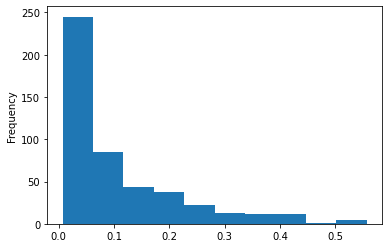

In [116]:
diam.diameters.plot.hist()

In [120]:
tmp = sparse_xarray_to_dataframe(network_data)

tmp.power_total.plot.hist()

AttributeError: 'Dataset' object has no attribute 'data'

# Data CADIOM

Load curve of the cadiom... 

<AxesSubplot:xlabel='data_ts'>

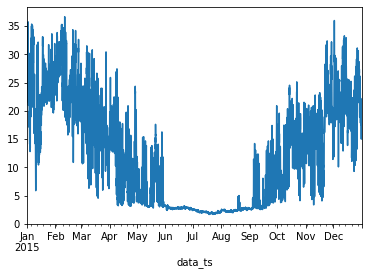

In [71]:
hourly_load_curve['qhww_mw'].plot()

In [72]:
hourly_load_curve.reset_index()

data_ts         p_h_kw       p_ww_kw       p_hww_kw    qhww_mw
0    2015-01-01 00:00:00  23770.770978  3218.137646  26988.908624  26.988909
1    2015-01-01 01:00:00  23645.795095  3234.364036  26880.159131  26.880159
2    2015-01-01 02:00:00  27391.122490  3248.105319  30639.227808  30.639228
3    2015-01-01 03:00:00  27361.085560  3211.426359  30572.511919  30.572512
4    2015-01-01 04:00:00  28042.326572  3184.709486  31227.036058  31.227036
...                  ...           ...          ...           ...        ...
8755 2015-12-31 19:00:00  15016.741853  3359.597191  18376.339044  18.376339
8756 2015-12-31 20:00:00  14168.120821  3382.140083  17550.260903  17.550261
8757 2015-12-31 21:00:00  16457.461141  3417.538003  19874.999144  19.874999
8758 2015-12-31 22:00:00  15173.565521  3462.245733  18635.811254  18.635811
8759 2015-12-31 23:00:00  16641.985790  3502.914871  20144.900661  20.144901

[8760 rows x 5 columns]

In [73]:
cadiom_lc = pd.read_csv(test_data_path / "LC_CADIOM_2015.csv", sep=",")
cadiom_lc.reset_index()

index           data_ts     mw
0         0  01.01.2015 00:00  31.00
1         1  01.01.2015 01:00  31.00
2         2  01.01.2015 02:00  32.55
3         3  01.01.2015 03:00  32.29
4         4  01.01.2015 04:00  33.90
...     ...               ...    ...
8755   8755  31.12.2015 19:00  30.01
8756   8756  31.12.2015 20:00  27.25
8757   8757  31.12.2015 21:00  24.31
8758   8758  31.12.2015 22:00  19.42
8759   8759  31.12.2015 23:00  17.77

[8760 rows x 3 columns]

In [74]:
list1 = list(hourly_load_curve['qhww_mw'])
list2 = list(cadiom_lc['mw'])

In [75]:
table_commune = pd.DataFrame(list(zip(list1, list2)),
               columns =['mw_model', 'mw_real'])
table_commune['difference'] = table_commune['mw_real'] - table_commune['mw_model']
table_commune['diff_relative'] = table_commune['difference'] / table_commune['mw_real'] * 100
table_commune

mw_model  mw_real  difference  diff_relative
0     26.988909    31.00    4.011091      12.939004
1     26.880159    31.00    4.119841      13.289809
2     30.639228    32.55    1.910772       5.870268
3     30.572512    32.29    1.717488       5.318947
4     31.227036    33.90    2.672964       7.884849
...         ...      ...         ...            ...
8755  18.376339    30.01   11.633661      38.765948
8756  17.550261    27.25    9.699739      35.595373
8757  19.874999    24.31    4.435001      18.243525
8758  18.635811    19.42    0.784189       4.038047
8759  20.144901    17.77   -2.374901     -13.364663

[8760 rows x 4 columns]

<AxesSubplot:>

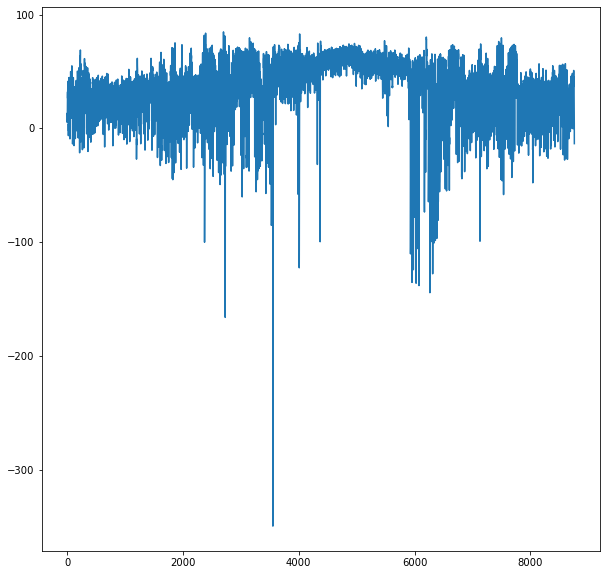

In [76]:
table_commune['diff_relative'].plot(figsize=(10,10))

In [77]:
daily_cumul_diff = table_commune['difference'].groupby(table_commune['difference'].index // 24).sum()
daily_mwh_mw_real = table_commune['mw_real'].groupby(table_commune['mw_real'].index // 24).sum()

In [78]:
daily_mwh_mw_real = table_commune['mw_real'].groupby(table_commune['mw_real'].index // 24).sum()

<AxesSubplot:>

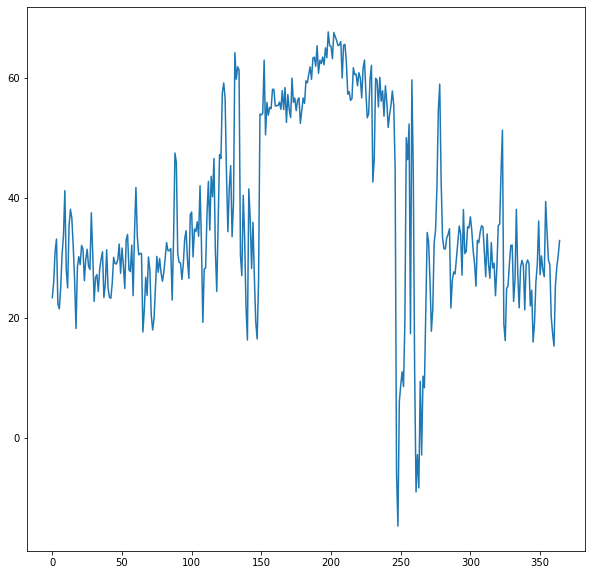

In [79]:
daily_diff_relative = daily_cumul_diff / daily_mwh_mw_real * 100
daily_diff_relative.plot(figsize=(10,10))

In [80]:
district.buildings

canton  gdenr            const_class  is_heated  total_surface  \
egid                                                                       
1002168       GE   6607  Maison à 3+ logements       True         1365.0   
1002169       GE   6607  Maison à 3+ logements       True         1740.0   
1002170       GE   6607  Maison à 3+ logements       True          590.0   
1002171       GE   6607  Maison à 3+ logements       True         1314.0   
1002174       GE   6607  Maison à 3+ logements       True          711.0   
...          ...    ...                    ...        ...            ...   
295149757     GE   6628  Maison à 3+ logements       True         1736.0   
295149873     GE   6628  Maison à 3+ logements       True         2079.0   
295149874     GE   6628  Maison à 3+ logements       True         1729.0   
295157513     GE   6618  Maison à 3+ logements       True         3176.0   
295168253     GE   6607  Réserv./silo/entrepôt      False         1269.0   

           total_surface_main_residence  source_sh  source_dhw stationid  \
egid                                                                       
1002168                             NaN     7520.0      7530.0       GVE   
1002169                             NaN     7520.0      7530.0       GVE   
1002170                             NaN     7520.0      7530.0       GVE   
1002171                             NaN     7520.0      7530.0       GVE   
1002174                             NaN     7530.0      7530.0       GVE   
...                                 ...        ...         ...       ...   
295149757                           NaN     7580.0      7570.0       GVE   
295149873                           NaN     7580.0      7570.0       GVE   
295149874                           NaN     7580.0      7570.0       GVE   
295157513                           NaN     7598.0      7570.0       GVE   
295168253                           NaN     7580.0      7580.0       GVE   

                                               point_geojson  ...  \
egid                                                          ...   
1002168    {'type': 'Point', 'coordinates': [6.077145022,...  ...   
1002169    {'type': 'Point', 'coordinates': [6.076966203,...  ...   
1002170    {'type': 'Point', 'coordinates': [6.076865675,...  ...   
1002171    {'type': 'Point', 'coordinates': [6.077462931,...  ...   
1002174    {'type': 'Point', 'coordinates': [6.078616995,...  ...   
...                                                      ...  ...   
295149757  {'type': 'Point', 'coordinates': [6.114379215,...  ...   
295149873  {'type': 'Point', 'coordinates': [6.113751919,...  ...   
295149874  {'type': 'Point', 'coordinates': [6.113803953,...  ...   
295157513  {'type': 'Point', 'coordinates': [6.090831865,...  ...   
295168253  {'type': 'Point', 'coordinates': [6.080916611,...  ...   

           qww_final_kwh  co2eq_h_kg  co2eq_ww_kg  co2eq_hww_kg  \
egid                                                                   
1002168     41595.321733  28751.921730   13393.693598   42145.615328   
1002169     53022.607923  36650.801326   17073.279751   53724.081078   
1002170     17978.930273  12427.570565    5789.215548   18216.786112   
1002171     40041.210811  27677.674105   12893.269881   40570.943986   
1002174     21666.134617  17505.285468    6976.495347   24481.780815   
...                  ...           ...            ...            ...   
295149757   52396.366815  20845.410679    1886.269205   22731.679884   
295149873   62748.874775  24964.060370    2258.959492   27223.019862   
295149874   52185.091143  20761.356604    1878.663281   22640.019885   
295157513   95858.790901      0.000000    3450.916472    3450.916472   
295168253       0.000000      0.000000       0.000000       0.000000   

           p_h_max1h_kw p_ww_max1h_kw  p_hww_max1h_kw p_h_max1d_kw  \
egid                                                                 
1002168       52.132095      6.910566       56.702737    35.04

<AxesSubplot:>

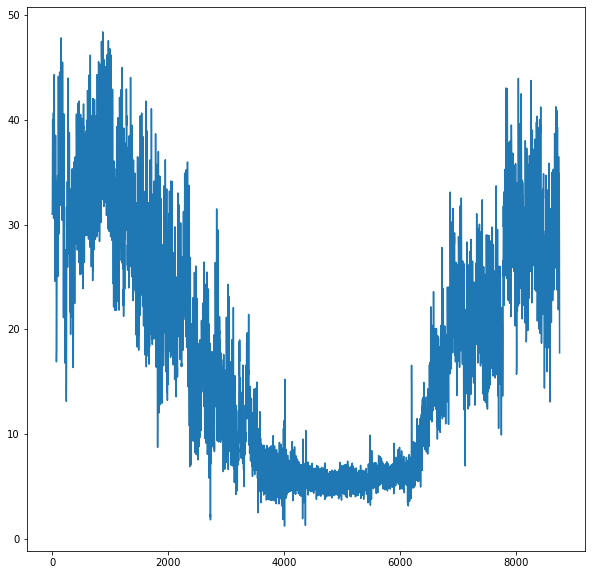

In [81]:
table_commune['mw_real'].plot(figsize=(10,10))

In [82]:
hourly_load_curve['qhww_mw'].plot(figsize=(10,10))

<AxesSubplot:xlabel='data_ts'>

In [84]:
test['total_surface'].sum()

1211531.0

In [86]:
test['q_hww_kwh'].sum()

KeyError: 'q_hww_kwh'